# Tarea: Hacer para N capas con un for

---
Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

---
Funciones varias

In [2]:
# Funciones de activación
def sf_threshold(input):
    output = input.copy()
    output[output<=0] = 0
    output[output>0] = 1
    return output

def sf_sigmoid(input):
    return 1/(1+np.exp(-input))

def sf_hyperbolic_tangent(input):
    return (np.exp(input) - np.exp(-input)) / (np.exp(input) + np.exp(-input))

def sf_relu(input):
    return np.maximum([0], input)

# Elección de función de activación
def step_function(self, input):
    if self.fun_act == 1:
        return sf_threshold(input)
    elif self.fun_act == 2:
        return sf_sigmoid(input)
    elif self.fun_act == 3:
        return sf_hyperbolic_tangent(input)
    elif self.fun_act == 4:
        return sf_relu(input)
    else:
        return "Ha habido un error: Función de activación incorrecta."

# Derivadas funciones de activación
def d_sigmoid(input):
    return (1 / 1 / (1 + np.exp(-input)) * (1 - 1 / (1 + np.exp(-input))))

def d_hyperbolic_tangent(input):
    return np.square(2 / (np.exp(input) + np.exp(-input)))

def d_relu(input):
    input[input<=0] = 0
    input[input>0] = 1
    return input

# Elección de derivada de función de activación
def f_act(self, sumas, i):
    if (self.lista_capas[len(self.lista_capas)-i].fun_act) == 2:
        return d_sigmoid(sumas[len(sumas)-i])
    if (self.lista_capas[len(self.lista_capas)-i].fun_act) == 3:
        return d_hyperbolic_tangent(sumas[len(sumas)-i])
    if (self.lista_capas[len(self.lista_capas)-i].fun_act) == 4:
        return d_relu(sumas[len(sumas)-i])

# Función y derivada del ecm
def f_ecm(r_esp, r_obt):
    return np.square(np.subtract(r_esp, r_obt)).mean()

def d_ecm(r_esp, r_obt):
    return np.subtract(r_esp, r_obt)

---
Código de la Capa

In [3]:
class Capa:
    def __init__(self, num_neuronas, num_entradas, fun_act):
        self.peso_input = np.random.random((num_entradas+1, num_neuronas))
        self.fun_act = fun_act

    # Entra una matriz de 1 x n y sale una matriz de 1 x n
    def get_output(self, input):
        input = np.insert(input, 0, 1)
        if (input.shape[0] == self.peso_input.shape[0]):
            self.suma = np.matmul(input, self.peso_input)
            return self.step_function()
        else: return "Ha habido un error: No coinciden el número de neuronas"

    # Decide qué hacer según la función de activación
    def step_function(self):
        if self.fun_act == 1:
            return sf_threshold(self.suma)
        elif self.fun_act == 2:
            return sf_sigmoid(self.suma)
        elif self.fun_act == 3:
            return sf_hyperbolic_tangent(self.suma)
        elif self.fun_act == 4:
            return sf_relu(self.suma)
        else:
            return "Ha habido un error: Función de activación incorrecta."

    # Función para mostrar los datos de la capa
    def print(self):
        print("Inputs: \n", self.peso_input)
        print("Input shape: \n", self.peso_input.shape)
        print("F Act: \n", self.fun_act)

---

In [4]:
class Red_Neuronal():
    def __init__(self,num_neuronas_capa, f_act_capa, num_inputs_1):
        self.lista_capas = []
        c = Capa(num_neuronas_capa[0], num_inputs_1, f_act_capa[0])
        self.lista_capas.append(c)
        for i in range(1, len(num_neuronas_capa)):
            c = Capa(num_neuronas_capa[i], num_neuronas_capa[i-1], f_act_capa[i])
            self.lista_capas.append(c)

    # Función para hacer los cálculos
    def test(self, inputs):
        for c in self.lista_capas:
            inputs = c.get_output(inputs)
        return inputs

    # Función para entrenar
    def train(self, input, out_esp , ratio):

        inputs, sumas = [], []
        for c in self.lista_capas:
            input = c.get_output(input)
            sumas.append(c.suma)
            inputs.append(input)

        # Derivadas de las funciones de activación
        df_act = self.f_act(sumas, 1)
        decm = d_ecm(np.array(input), out_esp)

        # Primera capa
        delta = decm * df_act # derivada f_coste * derivada f_activación

        pesos = self.lista_capas[-1].peso_input[1:]
        bias = self.lista_capas[-1].peso_input[0]

        self.lista_capas[-1].peso_input[1:] = pesos - inputs[-1].transpose() @ delta * ratio
        self.lista_capas[-1].peso_input[0] = bias - delta.mean() * ratio

        # Capas N
        for n in range(2, len(self.lista_capas)+1):
            pesos_tmp = pesos
            df_act = self.f_act(sumas, n)
            delta = delta @ pesos_tmp.transpose() * df_act # derivada f_coste * derivada f_activación * pesos anterior * derivada f_coste anterior

            pesos = self.lista_capas[-n].peso_input[1:]
            bias = self.lista_capas[-n].peso_input[0]

            # cambiar los self.pesos y self.bias
            self.lista_capas[-n].peso_input[1:] = pesos - inputs[-n].transpose() @ delta * ratio
            self.lista_capas[-n].peso_input[0] = bias - delta.mean() * ratio

    # Derivada según la función de activación
    def f_act(self, sumas, i):
        if (self.lista_capas[len(self.lista_capas)-i].fun_act) == 2:
            return d_sigmoid(sumas[len(sumas)-i])
        if (self.lista_capas[len(self.lista_capas)-i].fun_act) == 3:
            return d_hyperbolic_tangent(sumas[len(sumas)-i])
        if (self.lista_capas[len(self.lista_capas)-i].fun_act) == 4:
            return d_relu(sumas[len(sumas)-i])

    # Función para mostrar los datos de la red neuronal
    def print(self):
        c = 1
        for capa in self.lista_capas:
            print("Capa c: ")
            capa.print()
            print("---------")
            c += 1

---
Funciones para realizar el entrenamiento

In [5]:
def recorrido(red, inputs, outputs, iteraciones, ra, num_tests):
    for i in range(1, iteraciones+1):
        for input, output in zip(inputs, outputs):
            red.train(input, output, ra)
        if i % num_tests == 0:
            resultados = []
            for input, output in zip(inputs, outputs):
                resultado = red.test(input)
                resultados.append(resultado)
            print(f_ecm(resultados, outputs))

def recorrido_grafico(red, inputs, outputs, iteraciones, ra, num_tests):
    lista = []
    for i in range(1, iteraciones+1):
        for input, output in zip(inputs, outputs):
            red.train(input, output, ra)
        if i % num_tests == 0:
            resultados = []
            for input, output in zip(inputs, outputs):
                resultado = red.test(input)
                resultados.append(resultado)
            clear_output(wait=True)
            lista.append(f_ecm(resultados, outputs))
            plt.plot(lista)
            plt.show()

# Función para mostrar los resultados
# Parámetros:
# 		nn: red neuronal
#		X: la matriz con los datos de entrada
#		Y: la matriz con las salidas esperadas
#		lr: Ratio de aprendizaje
#		iterations: número de iteraciones que haremos sobre todo el conjunto de datos de entrenamiento
def show_training(nn, X, Y, lr, iterations):
    loss = []

    for i in range(iterations+1):
        # Entrenar la red neuronal
        
        for x in range(len(X)):
# TODO cambiar nn.train por vuestro método de entrenamiento
            nn.train(X[x], Y[x], lr)
        # Every 50 iterations, we check if network is learning showing the graphics
        if i % 50 == 0:
            results = []
            for x in range(len(X)):
                results.append(nn.test(X[x]))
# TODO cambiar "cost" por la llamada a vuestra función de coste:
            loss.append(f_ecm(results, Y))
            # Show how our network is predicting
            res = 50
            _x0 = np.linspace(-1.5, 1.5, res)
            _x1 = np.linspace(-1.5, 1.5, res)
            _Y  = np.zeros((res, res))
            for i0, x0 in enumerate(_x0):
                for i1, x1 in enumerate(_x1):
# TODO cambiar "test" por vuestro método de ejecutar o calcular
                    _Y[i0, i1] = nn.test(np.array([[x0, x1]]))
            
            plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
            plt.axis("equal")

            plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
            plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")

            clear_output(wait=True)
            plt.show()
            plt.plot(range(len(loss)), loss)
            plt.show()
            time.sleep(0.25)

---
Pruebas con datos manuales

In [6]:
ent = np.array([[0, 1, 1, 2, 1, 0]]).reshape(-1,1)
sal = np.array([[0, 0, 1, 1, 0, 1]]).reshape(-1,1)

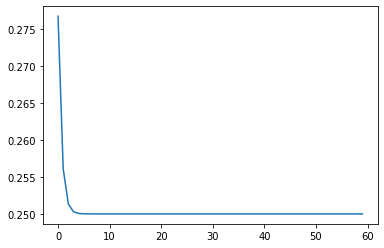

In [7]:
red = Red_Neuronal([1, 4, 3, 2, 1], [2, 3, 4, 3, 2], 1)
recorrido_grafico(red, ent, sal, 12000, 0.005, 200)

Pruebas con datos de un csv

In [8]:
inputs = pd.read_csv("03_inputs.csv", header=None).values
outputs = pd.read_csv("03_outputs.csv", header=None).values

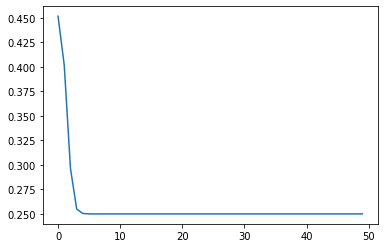

In [9]:
red = Red_Neuronal([8, 5, 7, 1], [2, 2, 2, 2], 2)
recorrido_grafico(red, inputs, outputs, 100, 0.001, 2)

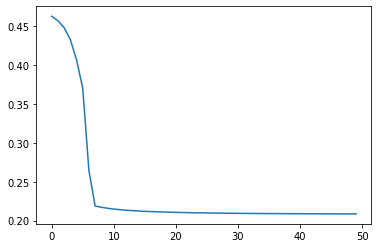

In [10]:
red = Red_Neuronal([8, 5, 7, 1], [3, 3, 3, 3], 2)
recorrido_grafico(red, inputs, outputs, 100, 0.001, 2)

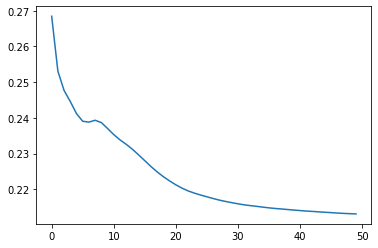

In [11]:
red = Red_Neuronal([8, 5, 7, 1], [4, 4, 4, 4], 2)
recorrido_grafico(red, inputs, outputs, 100, 0.001, 2)

Pruebas con mapa de entrenamiento

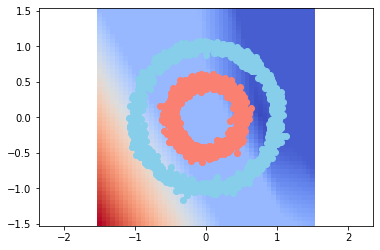

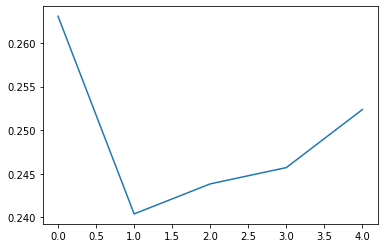

In [12]:
red = Red_Neuronal([8, 4, 1], [4, 4, 4], 2)
show_training(red, inputs, outputs, 0.0005, 200)

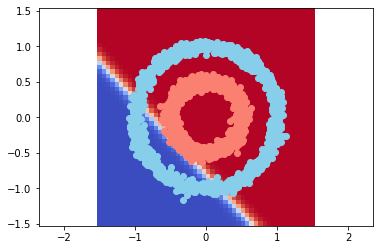

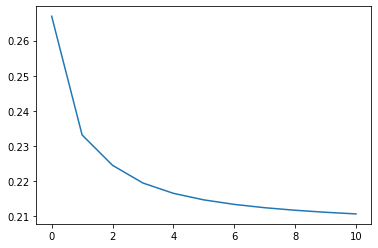

In [13]:
red = Red_Neuronal([2, 1], [3, 2], 2)
show_training(red, inputs, outputs, 0.003, 500)